In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from PIL import Image
import cv2
from collections import defaultdict
from tqdm import tqdm

In [27]:
def median(image, x, y, R = 1):
    res = []
    for c in range(image.shape[2]):
        arr = []
        for i in range(2 * R + 1):
            cell_x = x - R + i
            for j in range(2 * R + 1):
                cell_y = y - R + j
                if cell_x < 0 or cell_x >= image.shape[0] or cell_y < 0 or cell_y >= image.shape[1]:
                    arr.append(0)
                else:
                    arr.append(image[cell_x][cell_y][c])

        arr = sorted(arr)
        res.append(arr[len(arr) // 2])

    return res


def simple_sort(image, R = 1):
    res_image = np.zeros(image.shape)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            res_image[x][y] = median(image, x, y, R)

    return res_image


def huang(image, R = 1):
    res_image = np.zeros(image.shape)

    pad_image = np.concatenate((image[:R, :], image))
    pad_image = np.concatenate((pad_image, pad_image[-R:, :]))
    pad_image = np.concatenate((pad_image[:, :R], pad_image), axis=1)
    pad_image = np.concatenate((pad_image, pad_image[:, -R:]), axis=1)

    for c in range(image.shape[2]):
        for x in range(image.shape[0]):
            w = pad_image[x: x + 2 * R + 1, :R * 2 + 1, c].reshape(-1)
            counts = np.zeros(256)
            counts[:len(np.bincount(w))] += np.bincount(w)
            res_image[x, 0, c] = np.where(np.cumsum(counts) > len(w) // 2)[0][0]

            for y in range(1, image.shape[1]):
                p = pad_image[x: x + 2 * R + 1, y - 1, c]
                counts[:len(np.bincount(p))] -= np.bincount(p)
                p = pad_image[x: x + 2 * R + 1, y + 2 * R, c]
                counts[:len(np.bincount(p))] += np.bincount(p)
                res_image[x, y, c] = np.where(np.cumsum(counts) > len(w) // 2)[0][0]

    return res_image


def const_time(image, R = 1):
    res_image = np.zeros(image.shape)
    
    pad_image = np.concatenate((image[:R, :], image))
    pad_image = np.concatenate((pad_image, pad_image[-R:, :]))
    pad_image = np.concatenate((pad_image[:, :R], pad_image), axis=1)
    pad_image = np.concatenate((pad_image, pad_image[:, -R:]), axis=1)

    for c in range(image.shape[2]):
        column_histograms = np.array([np.bincount(pad_image[:2 * R, i, c], minlength=256) for i in range(pad_image.shape[1])])

        for x in range(res_image.shape[0]):
            w = pad_image[x: x + 2 * R + 1, : 2 * R + 1, c].reshape(-1)
            counts = np.zeros(256, dtype=int)
            counts[:len(np.bincount(w))] += np.bincount(w)
            res_image[x, 0, c] = np.where(np.cumsum(counts) > len(w) // 2)[0][0]

            for y in range(res_image.shape[1] + 2 * R):
                if x > 0:
                    column_histograms[y, pad_image[x - 1, y, c]] -= 1
                column_histograms[y, pad_image[x + 2 * R, y, c]] += 1

                if y >= 2 * R + 1:
                    counts -= column_histograms[y - 2 * R - 1]
                    counts += column_histograms[y]
                    res_image[x, y - 2 * R, c] = np.where(np.cumsum(counts) > len(w) // 2)[0][0]

    return res_image

In [14]:
def median_filter(name, R):
    image = plt.imread('picture.bmp')
    start_time = time.time()

    if name == "simple":
        itog = simple_sort(image, R)
    elif name == "huang":
        itpg = huang(image, R)
    elif name == "const_time":
        itog = const_time(image, R)
    elif name == "cv":
        image = cv2.imread('picture.jpeg')
        itog = cv2.medianBlur(image, 2 * R + 1)
    else:
        return -1
    
    time_work = time.time() - start_time
    return time_work

In [23]:
arr = defaultdict(list)
for R in tqdm([1, 2, 3, 5, 10, 25, 50, 75, 100]):
    for name in ["simple", "huang", "const_time", "cv"]:
        if R >= 10 and name == "simple":
            continue
        arr[name].append(median_filter(name, R))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [08:06<00:00, 54.01s/it]


In [24]:
image = plt.imread('picture.bmp')
megapixel_count = image.shape[0] * image.shape[1] / 1000000

for key in arr:
    arr[key] = np.array(arr[key]) * 1000 / megapixel_count

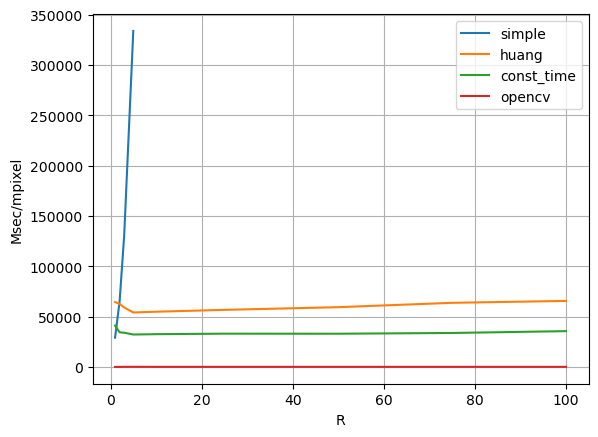

In [29]:
x = np.array([1, 2, 3, 5, 10, 25, 50, 75, 100])

plt.plot([1, 2, 3, 5], arr["simple"], label="simple")
plt.plot(x, arr["huang"], label="huang")
plt.plot(x, arr["const_time"], label="const_time")
plt.plot(x, arr["cv"], label="opencv")
plt.xlabel("R")
plt.ylabel("Msec/mpixel")
plt.grid()
plt.legend()
plt.show()

SIMPLE: O(R * log(R)), O(R^2) памяти  
HUANG: O(R + N), N - число уровней квантования, O(N) памяти  
CONST_TIME: O(N), N - число уровней квантования, O(A * N) памяти  
При R=1 имеет смысл использовать простую реализацию, а дальше только за констаетное время. Скорее всего при разных оптимизациях и реализациях получили бы разные данные 